# Sentiment Classifier on IMDB reviews

In this notebook, we build multiple neural network models to classify IMDB movie reviews by their sentiment.



### Load dependencies

In [1]:
import numpy as np
import itertools
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score,confusion_matrix
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# set random seed for reproducibility
np.random.seed(1234)
import warnings
warnings.filterwarnings('ignore')

## Load data

In [2]:
# load the dataset but only keep top 10000 words
top_words = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

In [3]:
print('There are {} in training and {} records in IMDB movie test set.'.format(len(X_train), len(X_test)))

There are 25000 in training and 25000 records in IMDB movie test set.


IMDB moive reviews have been preprocessed, and each review is encoded as a list of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

In [4]:
print('First record:')
X_train[0:1]

First record:


array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])],
      dtype=object)

In [5]:
print('Our label to classify sentiment is negative-0 and positive-1')
y_train[0:10]

Our label to classify sentiment is negative-0 and positive-1


array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0], dtype=int64)

## Preprocess data

In [6]:
# truncate and pad input sequences to make all reviews equal length
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [7]:
df_accuracy = pd.DataFrame(columns=['Model', 'Accuracy'])

# define input vector size for the first dense layer
embedding_vector_length = 32

### Functions to predict sentiment and note accuracy

In [8]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized Confusion Matrix:')
    print(cm)

In [9]:
def predict(model, name):
    y_pred = model.predict_classes(X_test)
    acc = accuracy_score(y_test, y_pred)
    cfs = confusion_matrix(y_test, y_pred)
    plt.figure()
    class_names = ["Positive", 'Negative']
    plot_confusion_matrix(cfs, classes=class_names, title=name)
    return acc

In [10]:
# function to evaluate model and record acurracy
def evalmodel(this_model, name):
    global df_accuracy
    scores = this_model.evaluate(X_test, y_test, verbose=0)
    test_accuracy = predict(this_model, name)
    df_accuracy = df_accuracy.append({'Model':name,
                                      'Accuracy': scores[1]
                                     }, ignore_index=True)
    return df_accuracy

## Design neural network architecture for Sequential Classification

### LSTM 

In [11]:
model_lstm = Sequential()
model_lstm.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model_lstm.add(LSTM(100))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           320000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
%%time
model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

Epoch 1/3
391/391 [==============================] - 375s 958ms/step - loss: 0.4784 - accuracy: 0.7595 - val_loss: 0.3842 - val_accuracy: 0.8409
Epoch 2/3
391/391 [==============================] - 370s 945ms/step - loss: 0.3020 - accuracy: 0.8762 - val_loss: 0.3182 - val_accuracy: 0.8696
Epoch 3/3
391/391 [==============================] - 373s 953ms/step - loss: 0.2227 - accuracy: 0.9158 - val_loss: 0.4174 - val_accuracy: 0.8616
Wall time: 18min 40s


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Normalized Confusion Matrix:
[[0.80352 0.19648]
 [0.08024 0.91976]]
Wall time: 2min 1s


,Model,Accuracy
0,LSTM,0.86164


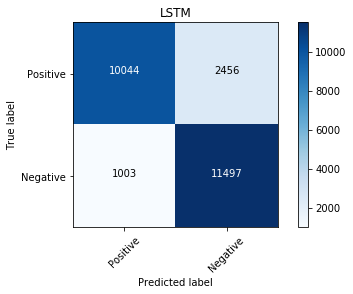

In [13]:
%%time
evalmodel(model_lstm, 'LSTM')

### LSTM with Dropout

In [14]:
from keras.layers import Dropout

model_lstm_dropout = Sequential()
model_lstm_dropout.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model_lstm_dropout.add(Dropout(0.2))
model_lstm_dropout.add(LSTM(100))
model_lstm_dropout.add(Dropout(0.2))
model_lstm_dropout.add(Dense(1, activation='sigmoid'))
model_lstm_dropout.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm_dropout.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
dropout (Dropout)            (None, 500, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
%%time
model_lstm_dropout.fit(X_train, y_train, epochs=3, batch_size=64)

Epoch 1/3
391/391 [==============================] - 298s 761ms/step - loss: 0.5192 - accuracy: 0.7414
Epoch 2/3
391/391 [==============================] - 300s 768ms/step - loss: 0.3221 - accuracy: 0.8687
Epoch 3/3
391/391 [==============================] - 312s 797ms/step - loss: 0.4352 - accuracy: 0.7951
Wall time: 15min 13s


Normalized Confusion Matrix:
[[0.85872 0.14128]
 [0.16496 0.83504]]
Wall time: 2min 7s


,Model,Accuracy
0,LSTM,0.86164
1,LSTM with Dropout,0.84688


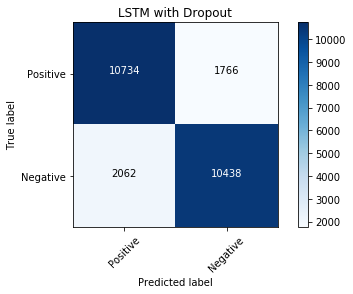

In [16]:
%%time
evalmodel(model_lstm_dropout, 'LSTM with Dropout')

### LSTM with double drop out, drop out between layers and drop out within layers of LSTM

In [17]:
model_dropout_recurrentdropout = Sequential()
model_dropout_recurrentdropout.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model_dropout_recurrentdropout.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_dropout_recurrentdropout.add(Dense(1, activation='sigmoid'))
model_dropout_recurrentdropout.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_dropout_recurrentdropout.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
%%time
model_dropout_recurrentdropout.fit(X_train, y_train, epochs=3, batch_size=64)

Epoch 1/3
391/391 [==============================] - 495s 1s/step - loss: 0.4997 - accuracy: 0.7578
Epoch 2/3
391/391 [==============================] - 510s 1s/step - loss: 0.2789 - accuracy: 0.8896
Epoch 3/3
391/391 [==============================] - 502s 1s/step - loss: 0.2179 - accuracy: 0.9180
Wall time: 25min 13s


Normalized Confusion Matrix:
[[0.89168 0.10832]
 [0.14576 0.85424]]
Wall time: 3min 2s


,Model,Accuracy
0,LSTM,0.86164
1,LSTM with Dropout,0.84688
2,LSTM with Dropout on LSTM and the Recurrent un...,0.87296


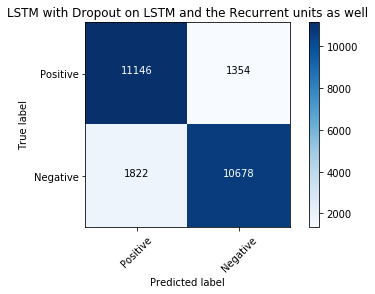

In [19]:
%%time
evalmodel(model_dropout_recurrentdropout, 'LSTM with Dropout on LSTM and the Recurrent units as well')

### LSTM and Convolutional Neural Network

In [20]:
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

model_lstm_cnn = Sequential()
model_lstm_cnn.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model_lstm_cnn.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_lstm_cnn.add(MaxPooling1D(pool_size=2))
model_lstm_cnn.add(LSTM(100))
model_lstm_cnn.add(Dense(1, activation='sigmoid'))
model_lstm_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm_cnn.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 250, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 376,405
Trainable params: 376,405
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
%%time
model_lstm_cnn.fit(X_train, y_train, epochs=3, batch_size=64)

Epoch 1/3
391/391 [==============================] - 136s 347ms/step - loss: 0.4324 - accuracy: 0.7842
Epoch 2/3
391/391 [==============================] - 130s 331ms/step - loss: 0.2107 - accuracy: 0.9219
Epoch 3/3
391/391 [==============================] - 129s 329ms/step - loss: 0.1487 - accuracy: 0.9470
Wall time: 6min 36s


Normalized Confusion Matrix:
[[0.89816 0.10184]
 [0.13648 0.86352]]
Wall time: 1min 11s


,Model,Accuracy
0,LSTM,0.86164
1,LSTM with Dropout,0.84688
2,LSTM with Dropout on LSTM and the Recurrent un...,0.87296
3,LSTM and CNN,0.88084


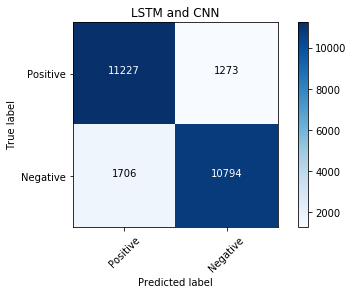

In [22]:
%%time
evalmodel(model_lstm_cnn, 'LSTM and CNN')

### LSTM, CNN with Flatten and FCN

In [23]:
# add flatten and FCN - fully connected network to optimize the model further
model_cnn_flatten_fcn = Sequential()
model_cnn_flatten_fcn.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model_cnn_flatten_fcn.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_cnn_flatten_fcn.add(MaxPooling1D(pool_size=2))
model_cnn_flatten_fcn.add(Flatten())
model_cnn_flatten_fcn.add(Dense(250,activation='relu'))
model_cnn_flatten_fcn.add(Dense(1, activation='sigmoid'))
model_cnn_flatten_fcn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_cnn_flatten_fcn.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 250)               2000250   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 251       
Total params: 2,323,605
Trainable params: 2,323,605
Non-trainable params: 0
____________________________________________

In [24]:
%%time
model_cnn_flatten_fcn.fit(X_train, y_train, epochs=3, batch_size=128)

Epoch 1/3
196/196 [==============================] - 14s 72ms/step - loss: 0.5182 - accuracy: 0.7052
Epoch 2/3
196/196 [==============================] - 14s 71ms/step - loss: 0.2073 - accuracy: 0.9210
Epoch 3/3
196/196 [==============================] - 14s 71ms/step - loss: 0.1320 - accuracy: 0.9537
Wall time: 42.9 s


Normalized Confusion Matrix:
[[0.85456 0.14544]
 [0.09592 0.90408]]
Wall time: 9.69 s


,Model,Accuracy
0,LSTM,0.86164
1,LSTM with Dropout,0.84688
2,LSTM with Dropout on LSTM and the Recurrent un...,0.87296
3,LSTM and CNN,0.88084
4,"LSTM, CNN w/ Flatten, FCN, Batch Size-128",0.87932


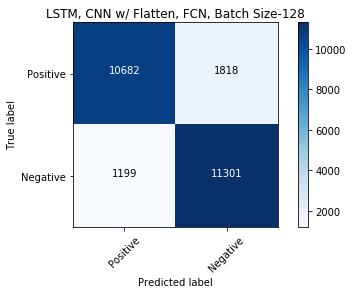

In [25]:
%%time
evalmodel(model_cnn_flatten_fcn, 'LSTM, CNN w/ Flatten, FCN, Batch Size-128')

In [26]:
%%time
model_cnn_flatten_fcn.fit(X_train, y_train, epochs=3, batch_size=64)

Epoch 1/3
391/391 [==============================] - 17s 45ms/step - loss: 0.1067 - accuracy: 0.9620
Epoch 2/3
391/391 [==============================] - 17s 45ms/step - loss: 0.0514 - accuracy: 0.9847
Epoch 3/3
391/391 [==============================] - 17s 44ms/step - loss: 0.0208 - accuracy: 0.9954
Wall time: 52.3 s


Normalized Confusion Matrix:
[[0.88832 0.11168]
 [0.16072 0.83928]]
Wall time: 9.16 s


,Model,Accuracy
0,LSTM,0.86164
1,LSTM with Dropout,0.84688
2,LSTM with Dropout on LSTM and the Recurrent un...,0.87296
3,LSTM and CNN,0.88084
4,"LSTM, CNN w/ Flatten, FCN, Batch Size-128",0.87932
5,"LSTM, CNN w/ Flatten, FCN, Batch Size-64",0.86380


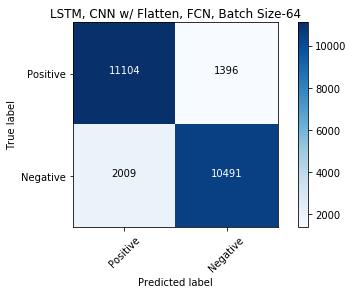

In [27]:
%%time
evalmodel(model_cnn_flatten_fcn, 'LSTM, CNN w/ Flatten, FCN, Batch Size-64')

<b>We have built model with one LSTM layer, added dropout on LSTM layer and recurrent input layer, then tried CNN, CNN with Flatten and Fully Connected Network. The training times are 18, 15, 25, 6, 1 minutes respectively. For an accuracy of 88%, last model with 1 minute training time seems to be better for our sentiment analysis.